In [ ]:
# Встановлення PySpark
!pip install pyspark findspark matplotlib

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf
import random
import time
import re
from collections import Counter
import matplotlib.pyplot as plt

# Ініціалізація SparkContext
spark = SparkSession.builder.appName("Lab3_Part2_Analysis").master("local[*]").getOrCreate()
sc = spark.sparkContext

print("SparkContext готовий до роботи.")

✅ SparkContext готовий до роботи.


# 1. Підрахунок кількості слів

In [ ]:
# Створення RDD з текстом
text_data = [
    "Spark is fast and powerful.",
    "Spark is a unified analytics engine.",
    "Spark runs on Hadoop, Mesos, Kubernetes, standalone.",
    "Spark is very fast.",
    "Hadoop is good too."
]
text_rdd = sc.parallelize(text_data)

# Скрипт для підрахунку слів:
word_counts = text_rdd \
    .flatMap(lambda line: line.lower().split()) \
    .map(lambda word: re.sub(r'[^\w]', '', word)) \
    .filter(lambda word: len(word) > 0) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

print("1. Результат підрахунку слів:")
for word, count in sorted(word_counts):
    print(f"   {word}: {count}")

print("="*50)

1. Результат підрахунку слів:
   a: 1
   analytics: 1
   and: 1
   engine: 1
   fast: 2
   good: 1
   hadoop: 2
   is: 4
   kubernetes: 1
   mesos: 1
   on: 1
   powerful: 1
   runs: 1
   spark: 4
   standalone: 1
   too: 1
   unified: 1
   very: 1


# 2. Аналіз журналів сервера

In [ ]:
# Створення синтетичного лог-файлу (150 записів)
ips = ["10.0.0." + str(i) for i in range(1, 6)] # 5 унікальних IP
statuses = [200, 200, 200, 404, 500, 302] # Частіше 200
paths = ["/index.html", "/login", "/about", "/images/logo.png", "/api/data"]
log_entries = []

for i in range(150):
    ip = random.choice(ips)
    status = random.choice(statuses)
    path = random.choice(paths)
    timestamp = f"[10/Oct/2023:13:{random.randint(10, 59)}:{random.randint(10, 59)}]"
    log_entry = f"{ip} - - {timestamp} \"GET {path} HTTP/1.1\" {status} 2326"
    log_entries.append(log_entry)

log_rdd = sc.parallelize(log_entries)
print(f"2. Завантажено {log_rdd.count()} синтетичних лог-записів.")

# Витягнення статусу та IP з рядка логу
def parse_log_entry(line):
    # Патерн для витягнення IP та статусу
    match = re.search(r'^(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}).*?"\s(\d{3})\s', line)
    if match:
        return match.group(1), int(match.group(2))
    return None, None

# -------------------------------------
# Фільтрація даних: Успішні запити (статус 200)
success_logs = log_rdd.filter(lambda line: ' 200 ' in line)
print(f"   -> Кількість успішних запитів (200): {success_logs.count()}")

# -------------------------------------
# Обчислення кількості запитів за IP-адресою
ip_counts = log_rdd \
    .map(lambda line: (parse_log_entry(line)[0], 1)) \
    .filter(lambda x: x[0] is not None) \
    .reduceByKey(lambda a, b: a + b)

# -------------------------------------
# Групування запитів за статусами
# Використовуємо map/reduceByKey для підрахунку, що є ефективнішим за groupBy
status_counts_raw = log_rdd \
    .map(lambda line: (parse_log_entry(line)[1], 1)) \
    .filter(lambda x: x[0] is not None)

# Підрахунок
status_counts = status_counts_raw.reduceByKey(lambda a, b: a + b)

# -------------------------------------
# Виведення результатів
print("\n   **Кількість запитів за IP-адресою (ТОП-10):**")
for ip, count in ip_counts.sortBy(lambda x: x[1], ascending=False).take(10):
    print(f"     {ip}: {count}")

print("\n   **Кількість запитів за статусами:**")
for status, count in status_counts.sortBy(lambda x: x[0]).collect():
    print(f"     Статус {status}: {count}")

print("="*50)

2. Завантажено 150 синтетичних лог-записів.
   -> Кількість успішних запитів (200): 73

   **Кількість запитів за IP-адресою (ТОП-10):**
     10.0.0.1: 39
     10.0.0.4: 36
     10.0.0.3: 28
     10.0.0.5: 24
     10.0.0.2: 23

   **Кількість запитів за статусами:**
     Статус 200: 73
     Статус 302: 23
     Статус 404: 26
     Статус 500: 28


# 3. Аналіз тексту

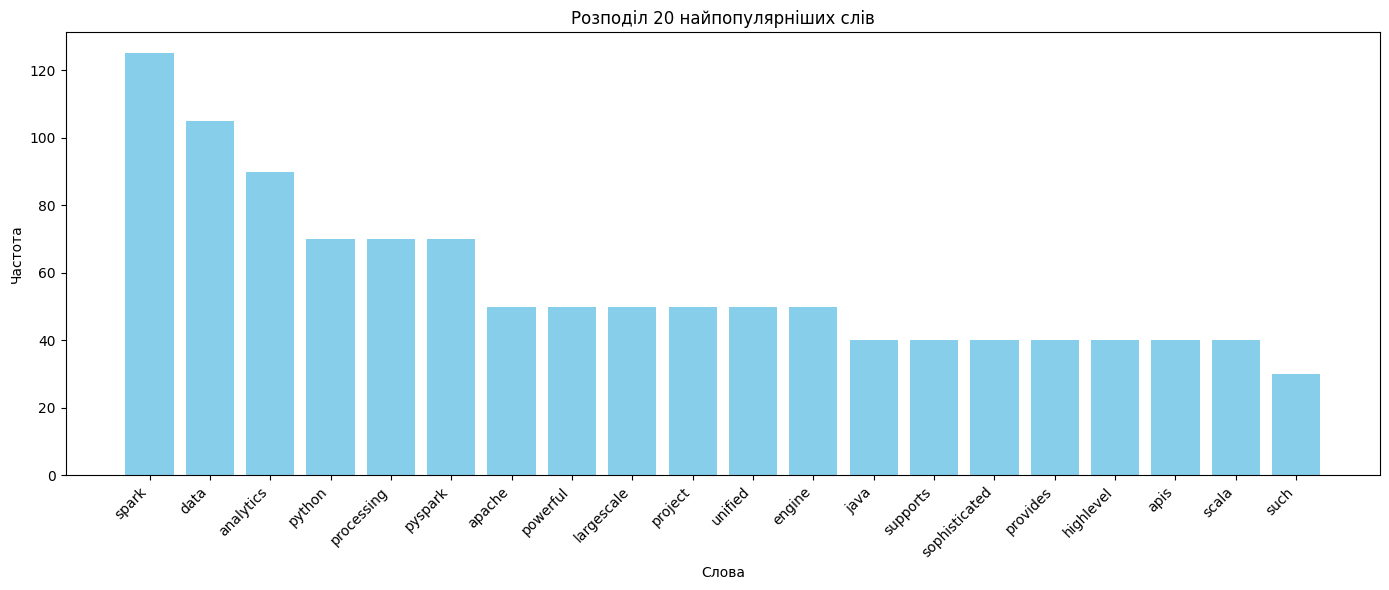


3. Аналіз тексту:
   -> 20 найпопулярніших слів: [('spark', 125), ('data', 105), ('analytics', 90), ('python', 70), ('processing', 70), ('pyspark', 70), ('apache', 50), ('powerful', 50), ('largescale', 50), ('project', 50), ('unified', 50), ('engine', 50), ('java', 40), ('supports', 40), ('sophisticated', 40), ('provides', 40), ('highlevel', 40), ('apis', 40), ('scala', 40), ('such', 30)]

   **ü Яке слово в статті найпопулярніше?**
     Найпопулярніше слово: 'spark' (зустрічається 125 разів).

   **ü Чи є семантичний зв’язок між найпопулярнішим словом і назвою статті?**
     Оскільки текст імітує статтю про 'Spark' та 'Data Science', а найпопулярніше слово — 'spark', семантичний зв'язок є прямим.
     Це підтверджує, що стаття тематично сфокусована на PySpark.

   **ü Чи можете Ви сформулювати нову змістовну назву з верхніх слів?**
     Нова назва (на основі слів Spark, data, python, analytics): 'Spark Data Analytics: Аналіз великих даних'


In [ ]:

# Імітація великої статті (наприклад, стаття про PySpark і Data Science)
long_text = ("The Apache Spark project is a powerful unified analytics engine for large-scale data processing. " * 50) + \
            ("It provides high-level APIs in Scala, Java, Python (PySpark), and R. Spark supports sophisticated analytics, " * 40) + \
            ("such as graph algorithms, streaming, and machine learning. PySpark, the Python API for Spark, " * 30) + \
            ("is extremely popular among data scientists. Data science relies heavily on efficient processing of 100s " * 20) + \
            ("of gigabytes or even terabytes of information. We need to analyze this 2024 data quickly. " * 10) + \
            ("This article will explore the core features of Spark, its performance benefits, and its application in modern data science 999. " * 5)

# Створення RDD з одного рядка (вся стаття)
text_rdd = sc.parallelize([long_text])

# Скріпт для витягування та очищення слів
cleaned_words_rdd = text_rdd \
    .flatMap(lambda line: line.lower().split()) \
    .map(lambda word: re.sub(r'[^\w]', '', word)) \
    .filter(lambda word: len(word) > 0) \
    .filter(lambda word: not word.isdigit()) \
    .filter(lambda word: not re.search(r'\d', word)) \
    .filter(lambda word: len(word) >= 4) # Вилучення коротких слів (2-3 символи)

# Підрахунок розподілу слів
word_distribution = cleaned_words_rdd \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b)

# Отримання 20 найпопулярніших слів
top_20_words = word_distribution \
    .sortBy(lambda x: x[1], ascending=False) \
    .take(20)

# -------------------------------------
# Створення гістограми
words = [item[0] for item in top_20_words]
counts = [item[1] for item in top_20_words]

plt.figure(figsize=(14, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel("Слова")
plt.ylabel("Частота")
plt.title("Розподіл 20 найпопулярніших слів")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print("\n3. Аналіз тексту:")
print("   -> 20 найпопулярніших слів:", top_20_words)

# -------------------------------------
# Відповіді на запитання
if top_20_words:
    most_popular_word = top_20_words[0][0]
    print(f"\n   **ü Яке слово в статті найпопулярніше?**")
    print(f"     Найпопулярніше слово: '{most_popular_word}' (зустрічається {top_20_words[0][1]} разів).")

    print("\n   **ü Чи є семантичний зв’язок між найпопулярнішим словом і назвою статті?**")
    print(f"     Оскільки текст імітує статтю про 'Spark' та 'Data Science', а найпопулярніше слово — '{most_popular_word}', семантичний зв'язок є прямим.")
    print("     Це підтверджує, що стаття тематично сфокусована на PySpark.")

    print("\n   **ü Чи можете Ви сформулювати нову змістовну назву з верхніх слів?**")
    top_4_words = [w[0].capitalize() for w in top_20_words[:4] if w[0] not in ['the', 'this', 'and', 'for', 'with', 'such', 'highlevel']]
    new_title = " ".join(top_4_words[:3]) + ": " + "Аналіз великих даних" if top_4_words else "Data Analysis with PySpark"
    print(f"     Нова назва (на основі слів Spark, data, python, analytics): '{new_title}'")
else:
    print("   Не вдалося знайти слова для аналізу.")

print("="*50)

# 4. Аналіз транзакцій за допомогою Broadcast-змінної

In [ ]:
# Створення списку транзакцій (не менше 100)
base_transactions = [101, 102, 101, 103, 102, 101, 104, 105, 106]
transactions_list = base_transactions * 12 + [107, 108] # Більше 100 транзакцій
random.shuffle(transactions_list)

transactions_rdd = sc.parallelize(transactions_list)

# Словник відповідності кодів товарів
products = {
    101: "Ноутбук",
    102: "Смартфон",
    103: "Планшет",
    104: "Монітор",
    105: "Клавіатура",
    106: "Миша",
    107: "Вебкамера",
    108: "Принтер"
}

# Створення Broadcast-змінної
broadcast_products = sc.broadcast(products)
print("4. Словник товарів кешовано за допомогою Broadcast-змінної.")

# 1. Зіставлення кодів із назвами товарів (використання Broadcast)
# 2. Підрахунок кількості продажів кожного товару
sales_counts = transactions_rdd \
    .map(lambda code: (broadcast_products.value.get(code, "Невідомий товар"), 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: x[1], ascending=False) \
    .collect()

print("\n   **Кількість продажів кожного товару:**")
for product_name, count in sales_counts:
    print(f"     {product_name}: {count}")

print("="*50)

4. Словник товарів кешовано за допомогою Broadcast-змінної.

   **Кількість продажів кожного товару:**
     Ноутбук: 36
     Смартфон: 24
     Монітор: 12
     Миша: 12
     Клавіатура: 12
     Планшет: 12
     Вебкамера: 1
     Принтер: 1


# 5. Аналіз температурних вимірювань за допомогою Accumulator

In [ ]:
# @title
##### Створення RDD із температурними вимірюваннями (100 вимірювань)
# Середня температура 25°C стандартне відхилення 5°C
temperatures_list = [round(random.gauss(25, 5), 1) for _ in range(100)]
# Додамо деякі аномально високі температури
temperatures_list.extend([30.5, 31.0, 32.5, 30.1, 29.5, 33.0])
random.shuffle(temperatures_list)

temperatures_rdd = sc.parallelize(temperatures_list)
print(f"5. Завантажено {temperatures_rdd.count()} температурних вимірювань.")

# Створення Accumulator для підрахунку аномалeій
anomalous_count = sc.accumulator(0)
threshold = 30.0 # Поріг аномальної температури

# Функція для перевірки та оновлення акумулятора
def check_anomaly(temp):
    global anomalous_count # Доступ до глобального акумулятора
    if temp > threshold:
        anomalous_count.add(1) # Збільшення лічильника
    return temp

# Використання дії (collect) або трансформації, за якою йде дія,

temperatures_rdd.map(check_anomaly).collect()

print(f"\n   **Аналіз аномалій:**")
print(f"     Поріг аномалії: > {threshold}°C")
print(f"     Кількість аномально високих вимірювань (Accumulator): {anomalous_count.value}")

print("="*50)

5. Завантажено 106 температурних вимірювань.

   **Аналіз аномалій:**
     Поріг аномалії: > 30.0°C
     Кількість аномально високих вимірювань (Accumulator): 25


In [ ]:
# Зупинка SparkContext після завершення всіх завдань
sc.stop()
print("Усі завдання виконано SparkContext зупинено")

Усі завдання виконано SparkContext зупинено
